# PHYS4003 Exam: Statistics Module


**Student name: Claire Morley**


## Academic Integrity

- The exam is open book, and you may draw on textbooks, lecture notes and provided material.
- You may not seek help from colleagues, friends, family, tutors or generative AI: that is considered contract cheating and is not permitted.
- This is an individual assignment, and you must submit your own work.


## Instructions for the exam
- This statistics component has one question worth 50 points.
- You have 10 minutes to start your setup and read the questions and 1 hour and 20 min to answer the questions and test run.
- You can submit your completed notebook as a Jupyter notebook through Blackboard.
- Some parts may require you to define new python variables/functions and test your work by running cells over and over or add new cells for yourself to check/test. This is fine. Just make sure that after you have tested what you return is a clean notebook that runs smoothly and only has the output that is requested in each question.
- Some questions rely on your work on questions before them in this exam. If you make a mistake in answering the earlier question, mark deduction for that specific mistake will not propagate in later questions that rely on that. If you cannot answer a former section at all, but you can address the latter section that relies on that, you are encouraged to write code snippet that would address that latter part with making assumptions and using hypothetical variables/input.
- Before submission, make sure that your notebook can be executed in a single run from beginning to end. If there are questions/parts that you have left blank or incomplete, which do not allow a complete computational run to be executed, comment them out and add an explanation about your partial work in the same cell (as a python comment block).
- Given the computational nature of this exam component and its time-criticality, do not hesitate to raise your hand if you encounter any issues.
- All the parts that require action (either in the code or text) are flagged by `<your turn>`.

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pylab as plt

sns.set_style("darkgrid")
sns.set_context("talk")
sns.color_palette("hls", 8)

# Setting matplotlib fonts
from matplotlib import rc
font = {'family': 'serif',
        'weight': 'bold',
        'size': '14'}
rc('font', **font)


# Below is a set of colors for matplotlib that is colorblind-friendly
# To use them in plotting commands, you can simply set "color=colorset[N]",
# where N is an integer in [0,16), reflecting the index of the colors below.
colorset = ['#000000','#00270C','#00443C','#005083',
            '#034BCA','#483CFC','#9C2BFF','#EB24F4',
            '#FF2DC2','#FF4986','#FF7356','#FFA443',
            '#EBD155','#D3F187','#D7FFC8','#FFFFFF']

## Data

We have count data of number of X-ray binaries (specific type of binary stellar systems containing a black hole or neutron star accreting from a sun-like star) in a sample of star clusters. For each star cluster we have a measurement of its mass $\hat{M}_i$ with some uncertainty on the mass $\hat{\sigma}_i$. We are trying to build a model based on the physical assumption that more massive star clusters should harbor higher number of X-ray binaries following a power-law.

Our data consists of $k=100$ clusters. We have:

Measured cluster masses (in units of $10^5$ solar mass)
$$\hat{M}_{\rm{obs}} = [\hat{M}_1,\cdots,\hat{M}_k] $$

Estimated uncertainty on measured cluster masses
$$\hat{\sigma}_{\rm{obs}} = [\hat{\sigma}_1,\cdots,\hat{\sigma}_k] $$

Number of X-ray binaries in clusters (as count values)
$$ \hat{N}_{\rm{XRB}} = [\hat{N}_1,\cdots,\hat{N}_k] $$



In [2]:
DATA = pd.read_csv('https://www.dropbox.com/scl/fi/6i7dqlbcpy1p823ns1gio/exam_data.csv?rlkey=m3zd4v5m1tkp6rj0gsig4yh4w&st=23fxe80w&dl=1')
DATA.head()

,data_mass,data_mass_er,data_N_XRB
0,10.811368,1.195869,46
1,17.334720,2.420520,99
2,13.770426,1.707962,63
3,17.338550,2.651178,72
4,10.648605,1.175006,43


### Q1: Visualize the data. [3 points]

Using the methods we have covered in the class, visualize the data with $\hat{N}_{\rm{XRB}}$ as a function of $\hat{M}_{\rm{obs}}$.

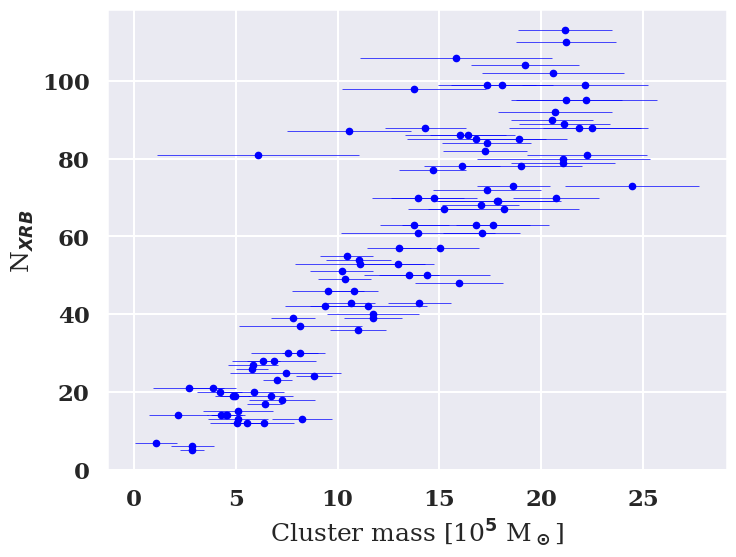

In [4]:
# <your turn>

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>
ax.errorbar(x=DATA['data_mass'],
            xerr=DATA['data_mass_er'],
            y=DATA['data_N_XRB'],
            fmt='.b', elinewidth=0.5)



# Plot cosmetics
ax.set_xlabel(r'Cluster mass [10$^5$ M$_\odot$]')
ax.set_ylabel(r'N$_{XRB}$');


## Our model

We propose that the expected number of X-ray binaries ($N_{\rm{XRB}}$) follows a Poisson distribution:

$$ N_{\rm{XRB}} \sim \textrm{Poisson}(\mu_{\rm{XRB}}) $$

where the Poisson "rate" $\mu_{\rm{XRB}}$ is a function of cluster mass $M$:

$$ \mu_{\rm{XRB}} = a M^b $$

and we wish to infer about $a$ and $b$. Let's assume that our physical understanding of cluster dynamics suggests:

$$ a \sim \textrm{Uniform}(\min=0,\max=5) $$
$$ b \sim \textrm{Uniform}(\min=0,\max=a) $$

However, we do not know the true values of $M$ for our clusters. We have measurements with uncertainties. So we decide to model the mass as:

$$ M \sim \textrm{TruncNorm}(\mu_M = \hat{M}_{obs}, \sigma=\sigma_M, \min=0) $$

where "$\textrm{TruncNorm}$" corresponds to a truncated normal distributions that is truncated at $\min=0$ to ensure non-negative values for mass.

Furthermore, assume that we are concerned that our uncertainties on the **measured** cluster masses $\hat{\sigma}_{obs}$ might be underestimated by a specific amount $s$ (the same amount for all clusters) that we want to infer. So we define $\sigma_M$ as:


$$ \sigma_M=\sqrt{\hat{\sigma}_{obs}^2+s^2}$$

and we define the prior on $s$ as:
$$ s \sim \textrm{Uniform}(\min=0,\max=2) $$


### Q2: Build the model. [8 points]

Build a PyMC model with the variables above and visualize its plate notation.

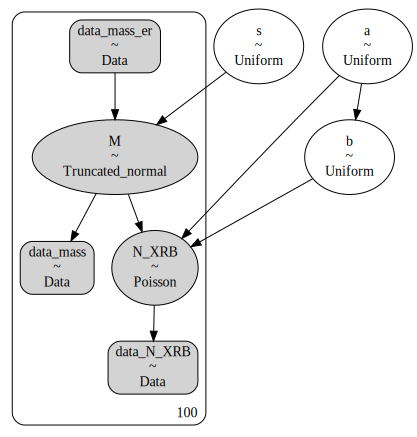

In [13]:
# <your turn>

with pm.Model() as XRB_model:
    ## Define your model here
    data_mass=pm.Data('data_mass',DATA['data_mass'])
    data_mass_er=pm.Data('data_mass_er',DATA['data_mass_er'])

    data_N_XRB=pm.Data('data_N_XRB',DATA['data_N_XRB'])


    a=pm.Uniform('a',0,5)
    b=pm.Uniform('b',0,a)



    s=pm.Uniform('s',0,2)
    sigma_M=(data_mass_er ** 2 + s **2) **0.5

    M=pm.TruncatedNormal('M',mu=data_mass,sigma=sigma_M,lower=0,observed=data_mass)



    nu_XRB=a * M**b
    N_XRB=pm.Poisson('N_XRB',nu_XRB,observed=data_N_XRB)
# your plate notation here

pm.model_to_graphviz(XRB_model)






## Prior checking

### Q3: Perform prior sampling. [4 points]

Perform the following steps (these can be done in a single cell or in a set of consecutive cells):
- a: Perform prior and prior-predictive sampling from the model with 2000 draws.
- b: Visualize the joint and marginal distributions of priors for $a,b,s$.
- c: Interpret your prior samples as visualized in part b in the context of how we have defined our priors. Are there any structures in the joint and marginal distributions? are they expected?

In [14]:
# <your turn>
# a:

with XRB_model:
    XRB_model_sample_prior_predictive = pm.sample_prior_predictive(draws=2000)

XRB_model_sample_prior_predictive



Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([[<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='b'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='a', ylabel='s'>, <Axes: xlabel='b'>,
        <Axes: xlabel='s'>]], dtype=object)

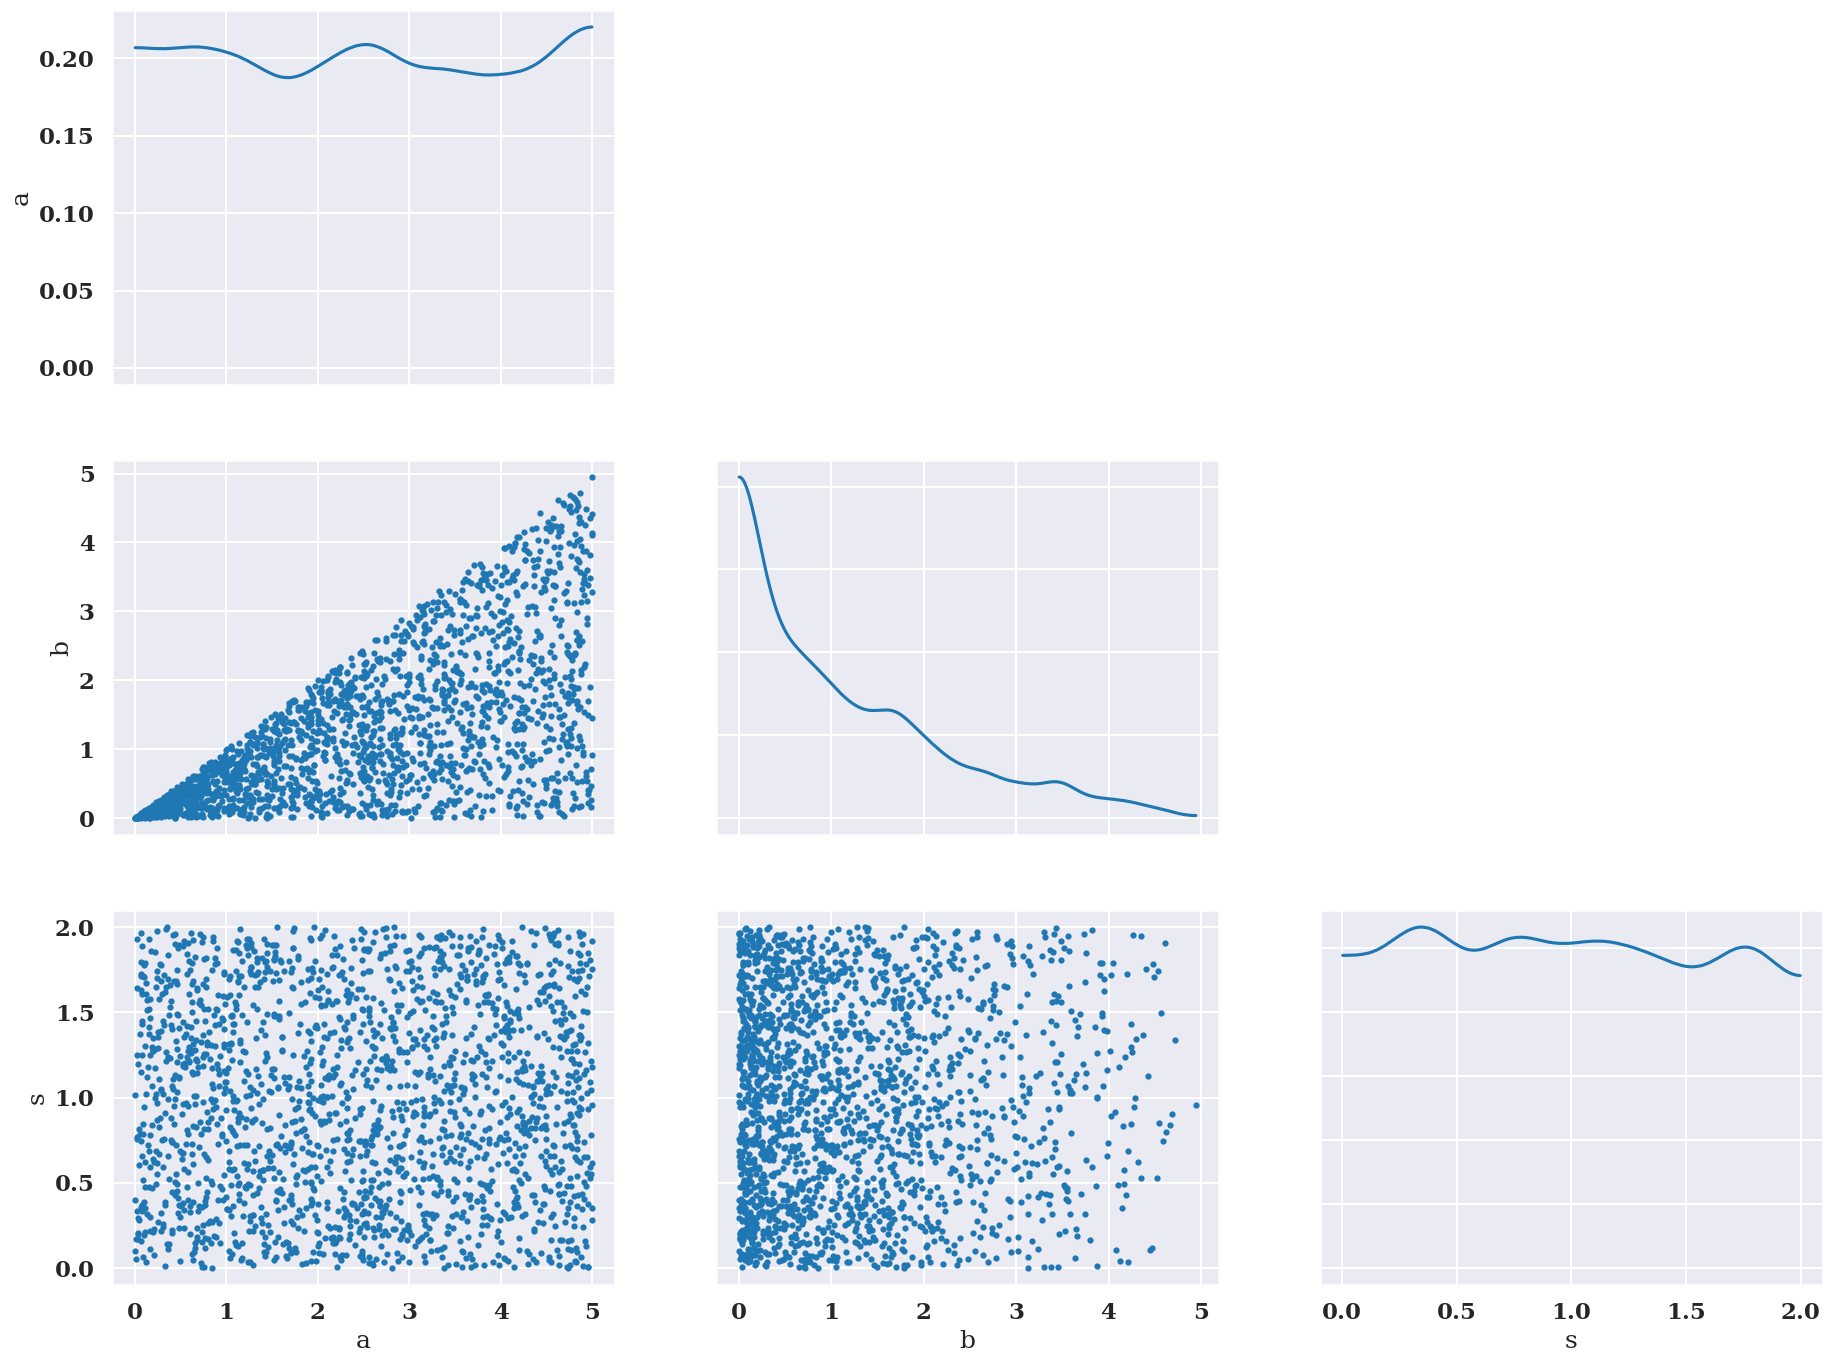

In [15]:
# <your turn>
# b:

az.plot_pair(XRB_model_sample_prior_predictive, group="prior",var_names=["a","b","s"],marginals=True)




`<your turn>`

*part c: Are there any structures in the joint and marginal distributions? are they expected? *
a is uniformly distributed across the defined range, as is s. There is no correlation between a and s, as expected - they do not have any dependence on each other, both are uniform distributions.

The prior for b is defined as a uniform distribution with a maximum of a. As we would expect, there is a correlation between a and b: the maximum value of b depends on the value of a.

b is clustered near the lower bound of 0, and falls off at higher values. This makes sense, as it relies on the a parameter for an upper boundary, so for low a the b value is distributed uniformly over a lower region.

## Posterior sampling

### Q4: Perform sampling from the posterior distribution. [6 points]

- a: Perform sampling from the posterior, with sufficient number of warm-up draws and post-warm up samples (you can discard the warm-up sample).
- b: Demonstrate convergence of your sampling via appropriate metrics and visualizations (Restrict your inspection to $a,b,s$).

In [18]:
# <your turn>
# a:
# You can add aditional cells if needed.

with XRB_model:
    XRB_model_mcmc_sample = pm.sample(draws=500,tune=100,chains=2,discard_tuned_samples=False)

XRB_model_mcmc_sample


KeyboardInterrupt: 

In [19]:
!wget https://raw.githubusercontent.com/bersavosh/P4003/refs/heads/main/Exam/contingency.py
!wget https://github.com/bersavosh/P4003/raw/refs/heads/main/Exam/fake_XRB_model_mcmc_sample.nc
!wget https://github.com/bersavosh/P4003/raw/refs/heads/main/Exam/fake_XRB_model_sample_prior_predictive.nc
!wget https://github.com/bersavosh/P4003/raw/refs/heads/main/Exam/fake_data.csv
import contingency

--2025-09-26 04:32:48--  https://raw.githubusercontent.com/bersavosh/P4003/refs/heads/main/Exam/contingency.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897 [text/plain]
Saving to: ‘contingency.py’

contingency.py      100%[===================>]     897  --.-KB/s    in 0s      

2025-09-26 04:32:48 (35.0 MB/s) - ‘contingency.py’ saved [897/897]

--2025-09-26 04:32:48--  https://github.com/bersavosh/P4003/raw/refs/heads/main/Exam/fake_XRB_model_mcmc_sample.nc
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bersavosh/P4003/refs/heads/main/Exam/fake_XRB_model_mcmc_sample.nc [following]
--2025

In [20]:
contingency.XRB_model_mcmc_sample

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [58]:
contingency.XRB_model_sample_sample_prior_predictive


fit_summary = pm.summary(contingency.XRB_model_mcmc_sample, var_names=['a','b','s'], hdi_prob=0.68)
fit_summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.691,0.434,3.211,4.093,0.012,0.007,1148.0,306.0,1.00
b,0.842,0.045,0.794,0.885,0.001,0.001,1171.0,394.0,1.00
s,1.491,0.311,1.321,1.948,0.016,0.008,416.0,639.0,1.01


Text(0.5, 0.98, 'Posterior')

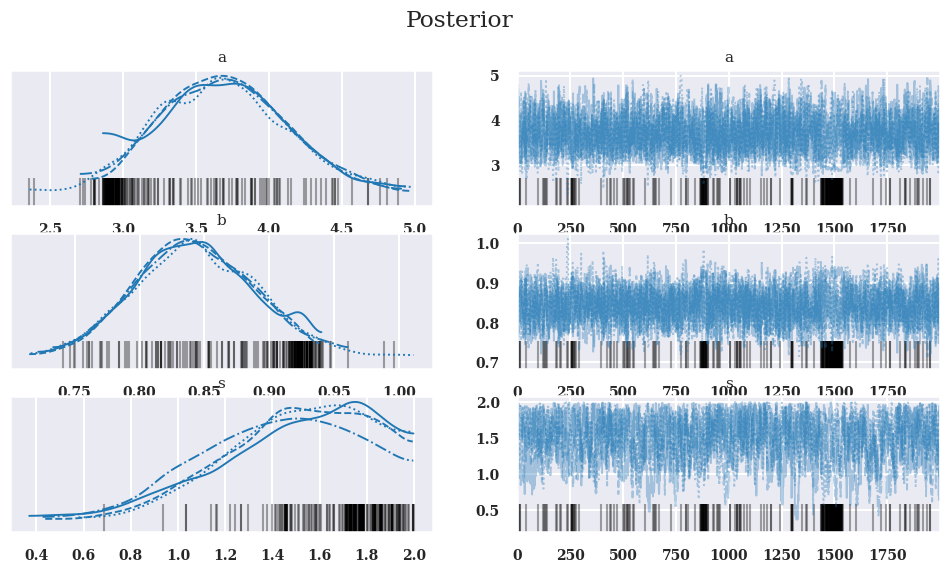

In [22]:
# Posterior
az.plot_trace(contingency.XRB_model_mcmc_sample, var_names=['a','b','s'])
plt.suptitle('Posterior')

# # Warmup
# az.plot_trace(q1_mcmc_sample.warmup_posterior, var_names=['a','b','s'],)
# plt.suptitle('Posterior with warmup included')

Each paramater of a,b,s has reached the 'fuzzy caterpillar' phase which indicates convergence. Each of the four chains follows the same distribution for each parameter. And from the fit summary, rhat is ~1 for each parameter.

### Q5: visualize and comment on posterior joint distributions for $a,b,s$. [5 points]

array([[<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='b'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='a', ylabel='s'>, <Axes: xlabel='b'>,
        <Axes: xlabel='s'>]], dtype=object)

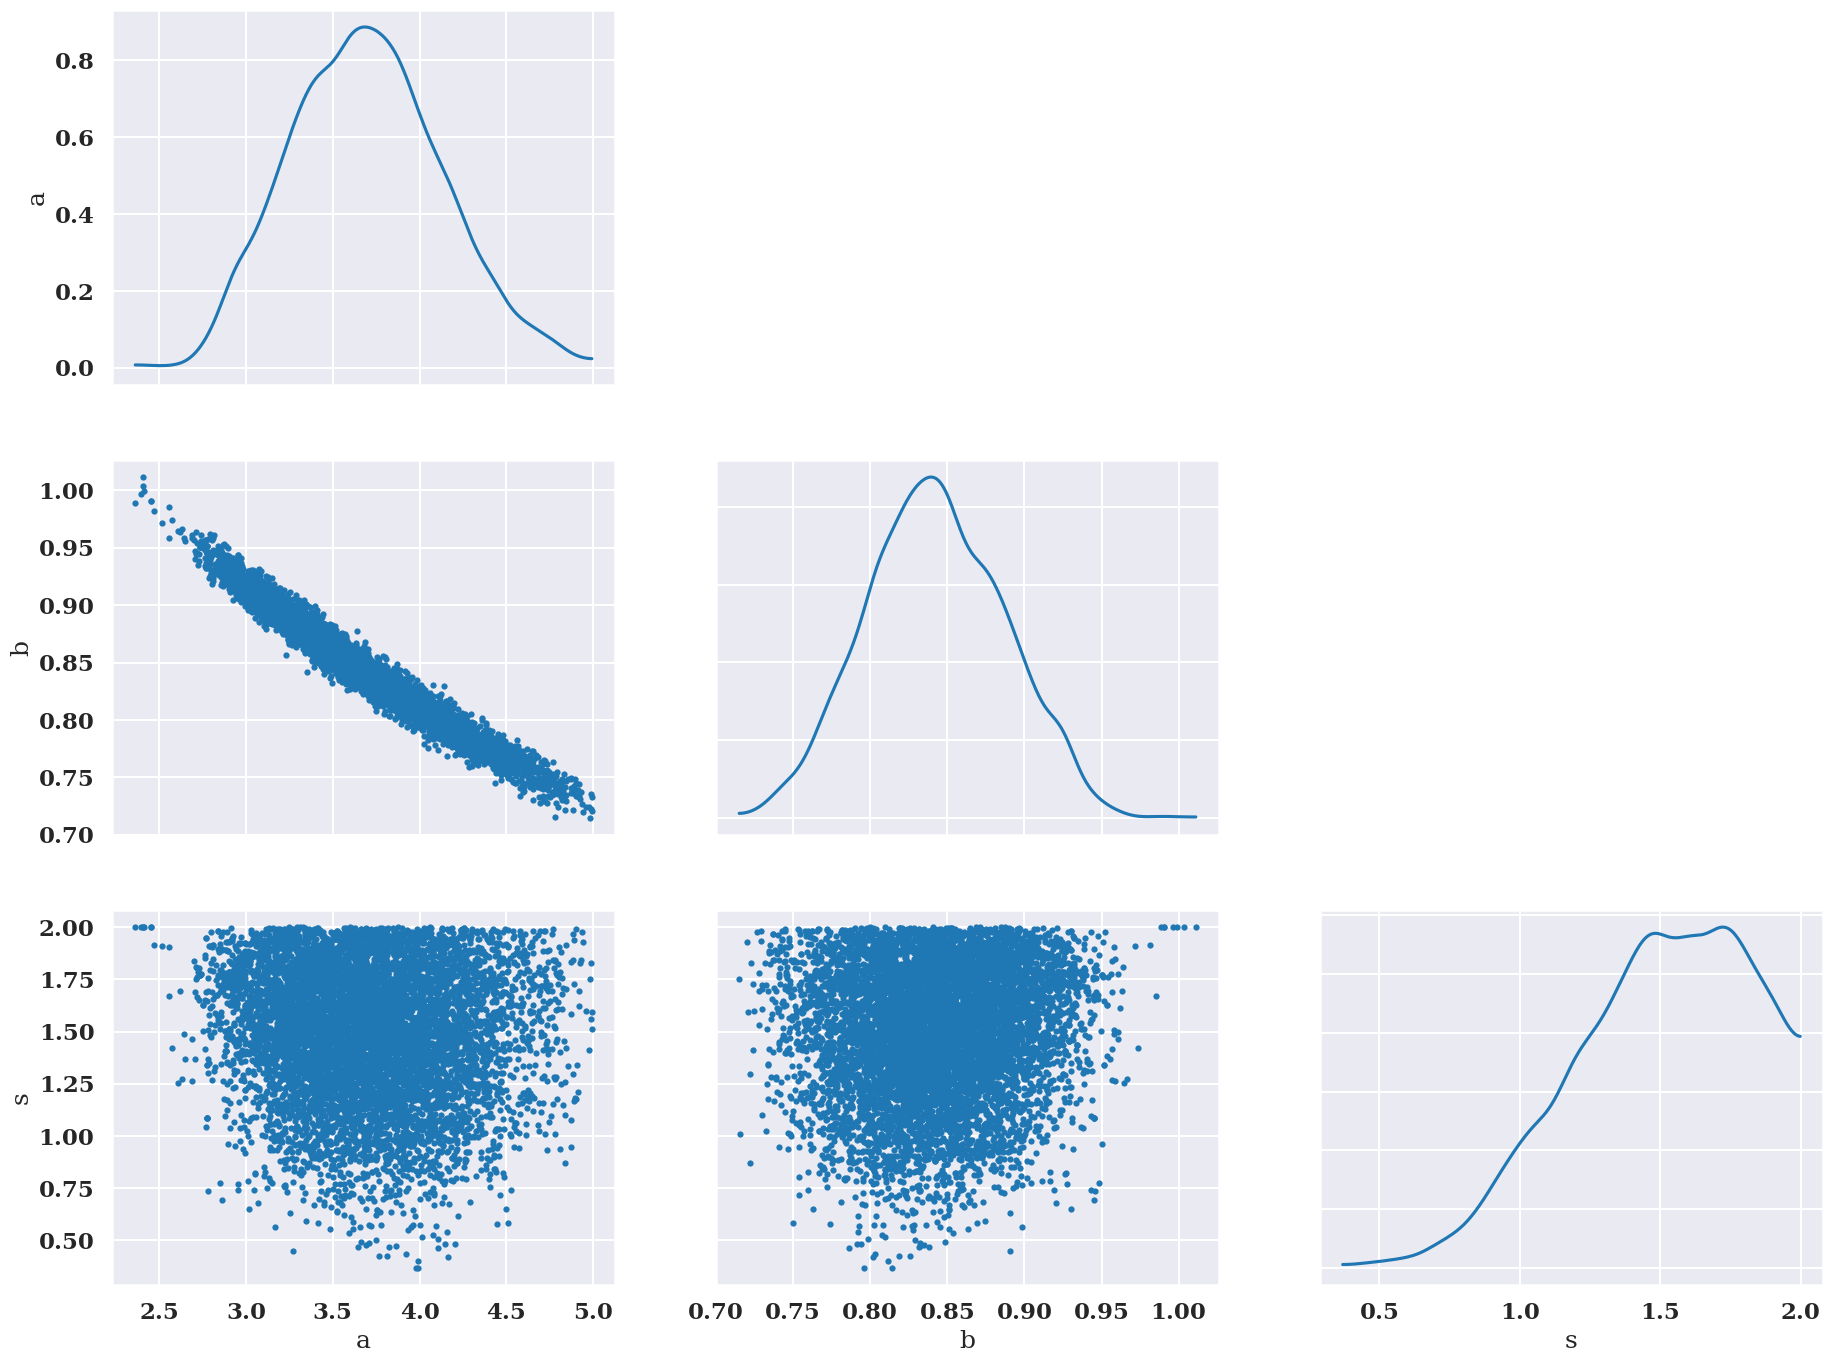

In [24]:
# <your turn>


az.plot_pair(contingency.XRB_model_mcmc_sample, group="posterior",var_names=["a","b","s"],marginals=True)


`<your turn>`

*Comment on the correlations in cell. Think of corrections in the context of our mathematical model.*
Comment on posterior joint distributions for  𝑎,𝑏,𝑠

*a* and *b* are strongly correlated, with an negative, approximately linear relationship: a larger *a* corresponds to a smaller *b*.
*a,s* and *b,s* are also correlated, in approximately circular clusters.



## Posterior predictions

### Q6: Perform posterior-predictive sampling for $N_{XRB}$ and plot the posterior-predictive sample's 95% HDI on top of your data for $N_{XRB}$ against cluster mass. [4 points]

In [60]:
# <your turn>
## Sampling

with XRB_model:
  pm.sample_posterior_predictive(contingency.XRB_model_mcmc_sample, extend_inferencedata=True)

contingency.XRB_model_mcmc_sample

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

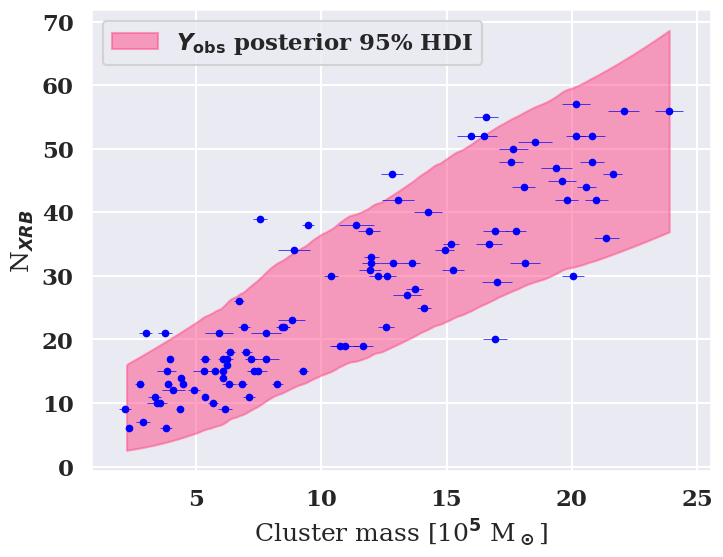

In [61]:
# <your turn>
## plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x=contingency.DATA['data_mass'],
            xerr=contingency.DATA['data_mass_er'],
            y=contingency.DATA['data_N_XRB'],
            fmt='.b', elinewidth=0.5)



az.plot_hdi(contingency.XRB_model_sample_sample_prior_predictive.constant_data['mass'],contingency.XRB_model_mcmc_sample.posterior_predictive['N_XRB'],hdi_prob=0.95,fill_kwargs={'color':colorset[9],'label':r'$Y_{\rm{obs}}$ posterior 95% HDI'})
ax.legend()

# testmass=np.linspace(0,25,100)
# testmu=3 * testmass ** 1.15
# ax.plot(testmass,testmu)

# Plot cosmetics
ax.set_xlabel(r'Cluster mass [10$^5$ M$_\odot$]')
ax.set_ylabel(r'N$_{XRB}$');

### Q7: Comment on whether you think the model describes the data in a reasonable manner. [6 points]


`<your turn>`

*Comment on the model compared to data.*


[OLD DATA] Definitely not. It seems reasonable for low cluster masses, but severely under-predicts the observations at higher masses. I would expect for the model to have used a higher b value to get a steeper power-law relation. This might be due to the dependence on b over a, which means b is clustered towards the lower end of the prior range. Overall, this model does not describe the data in a reasonable manner.

[CONTINGENCY DATA] It does seem to reasonably describe the data. Visually, 95% of means if the data should fall within that HDI range. It encompasses most data points, though it seems to underestimate the data a bit - many more points are outside the range above the 95% HDI than below it.

### Q8: Assess influence of priors on posteriors for $a,b,s$ and comment whether priors on any parameter has been influential and in what way. [6 points]

In [39]:
# Run this cell once without modification to combine the inference data sets
# If you are using the contingency dataset, add "contingency." before the idata names (e.g., contingency.XRB_model_mcmc_sample)

contingency.XRB_model_mcmc_sample.extend(contingency.XRB_model_sample_sample_prior_predictive)

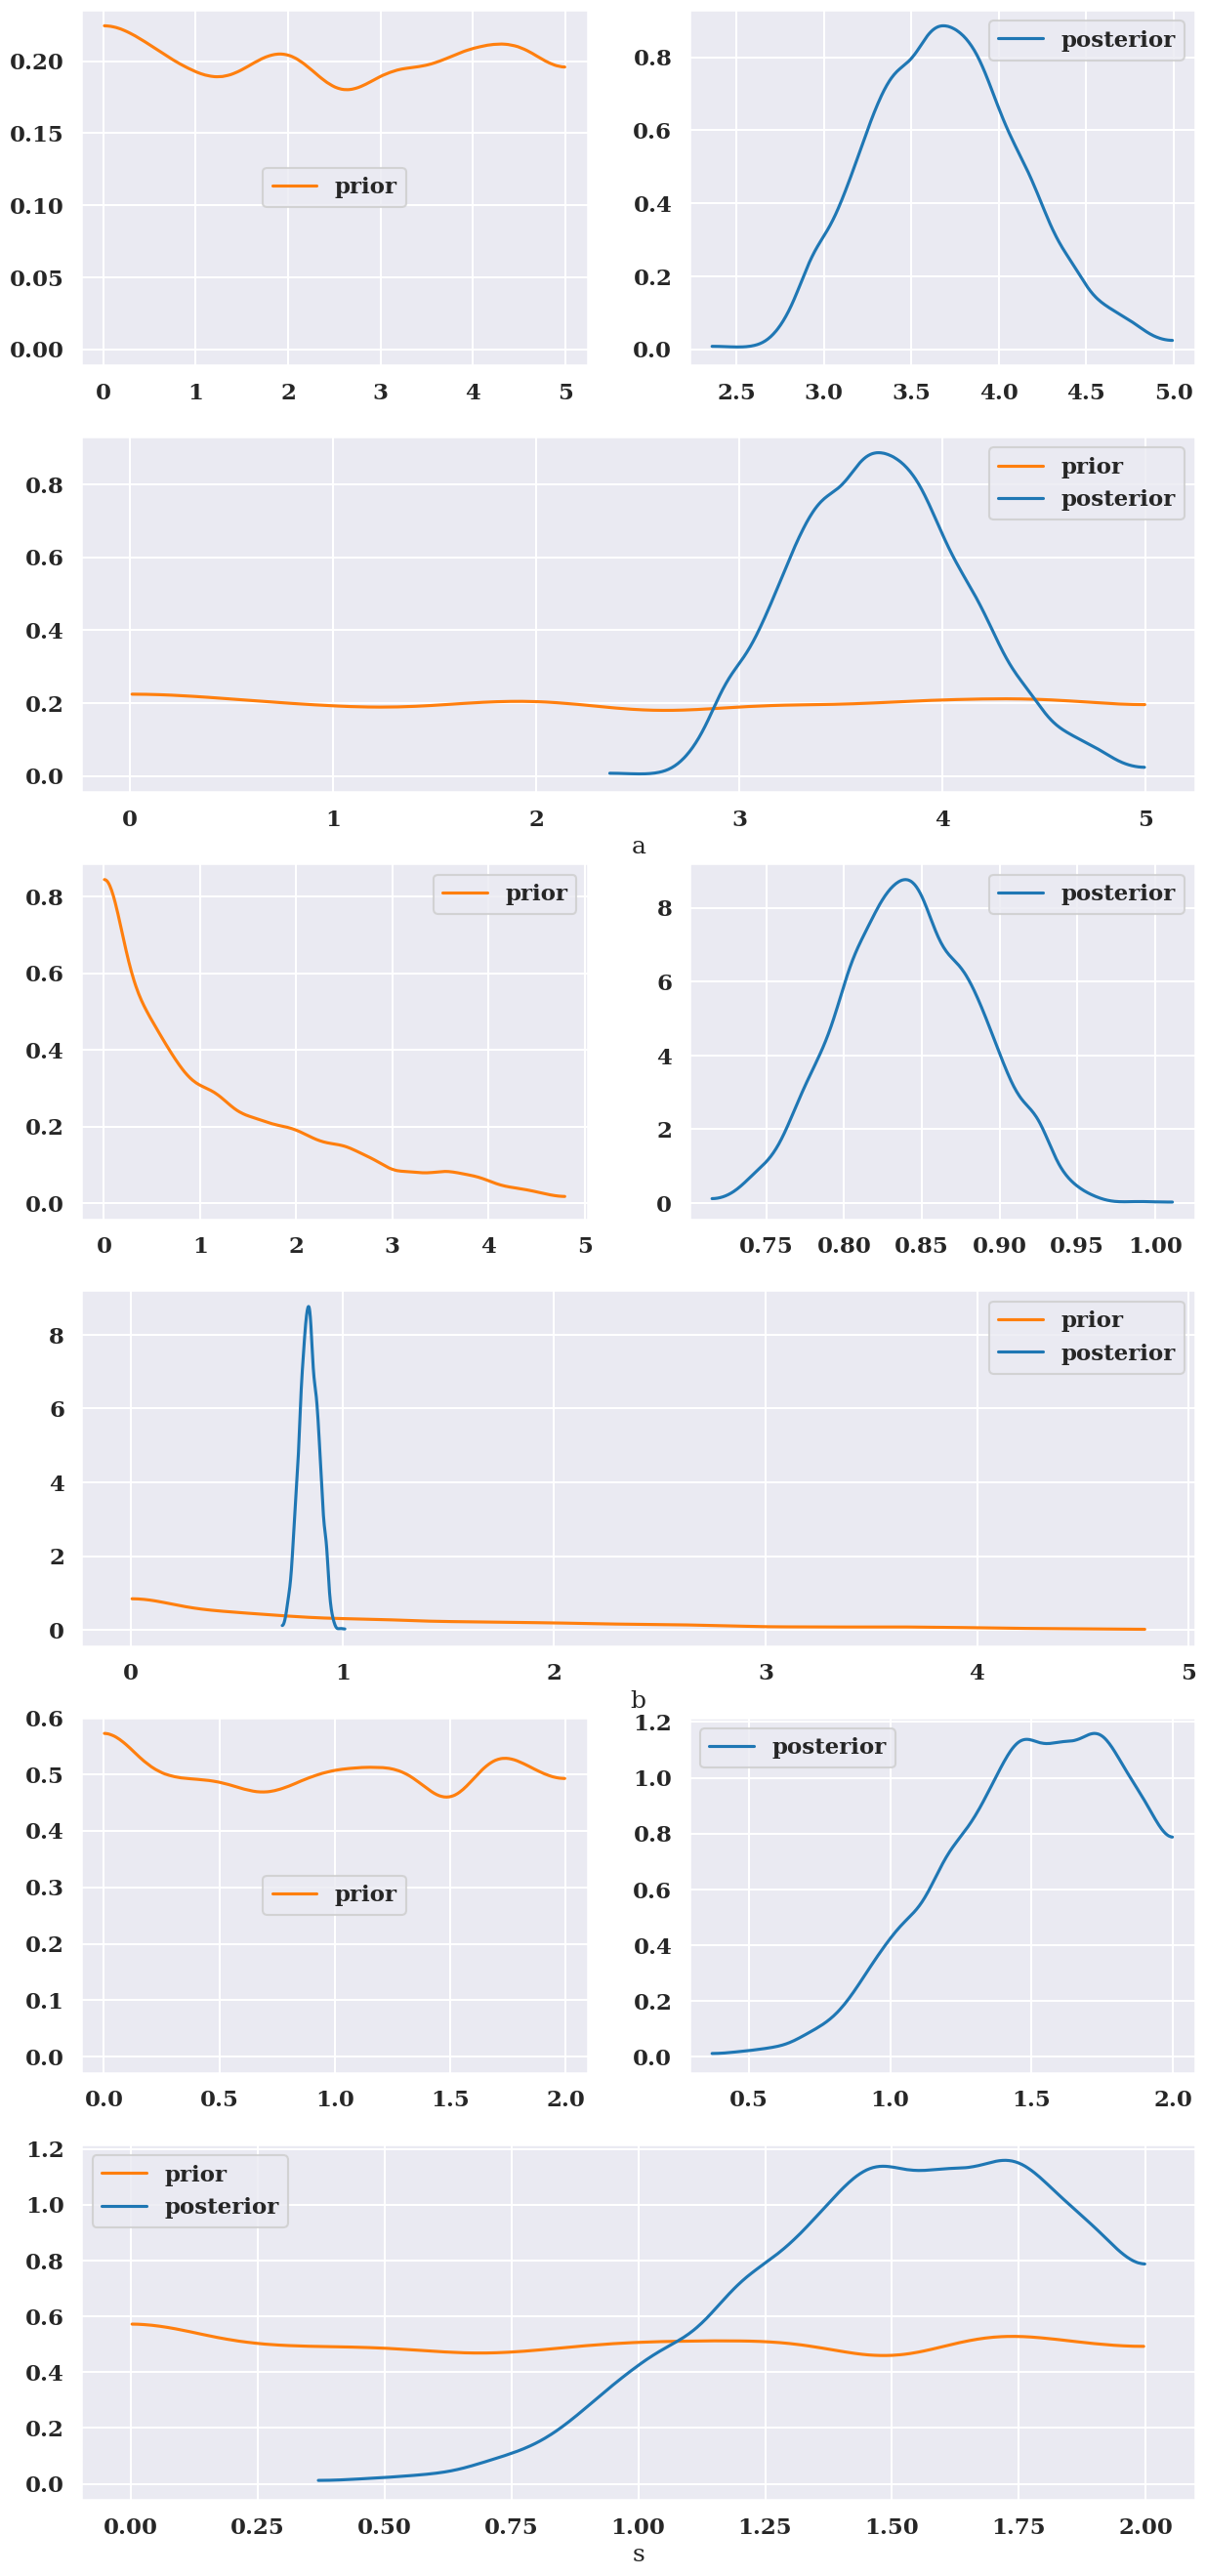

In [41]:
# <your turn>

az.plot_dist_comparison(contingency.XRB_model_mcmc_sample,var_names=['a','b','s']);
# ax_pw = az.plot_pair(contingency.XRB_model_mcmc_sample,
#                      group='prior',
#                      marginals=True,
#                      scatter_kwargs={'alpha': 0.2, 'color': colorset[4]},
#                      marginal_kwargs={'color': colorset[4]},var_names=['a','b','s'])




`<your turn>`

*Influence of priors on posteriors*
The priors don't seem to be influential on the posteriors. For each parameter, the prior is broad and flat compared to the posterior. In the case of b, the prior peaks around 0, but visually it's clear that the peak in the posterior is both at a different value of b, and much more sharply peaked than the prior, so there seems to be minimal influence.


### Point and interval estimation

#### Q9: Visualize marginal posterior samples of $a,b,s$ and report reasonable point and interval estimations for all three. [4 points]

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 's'}>], dtype=object)

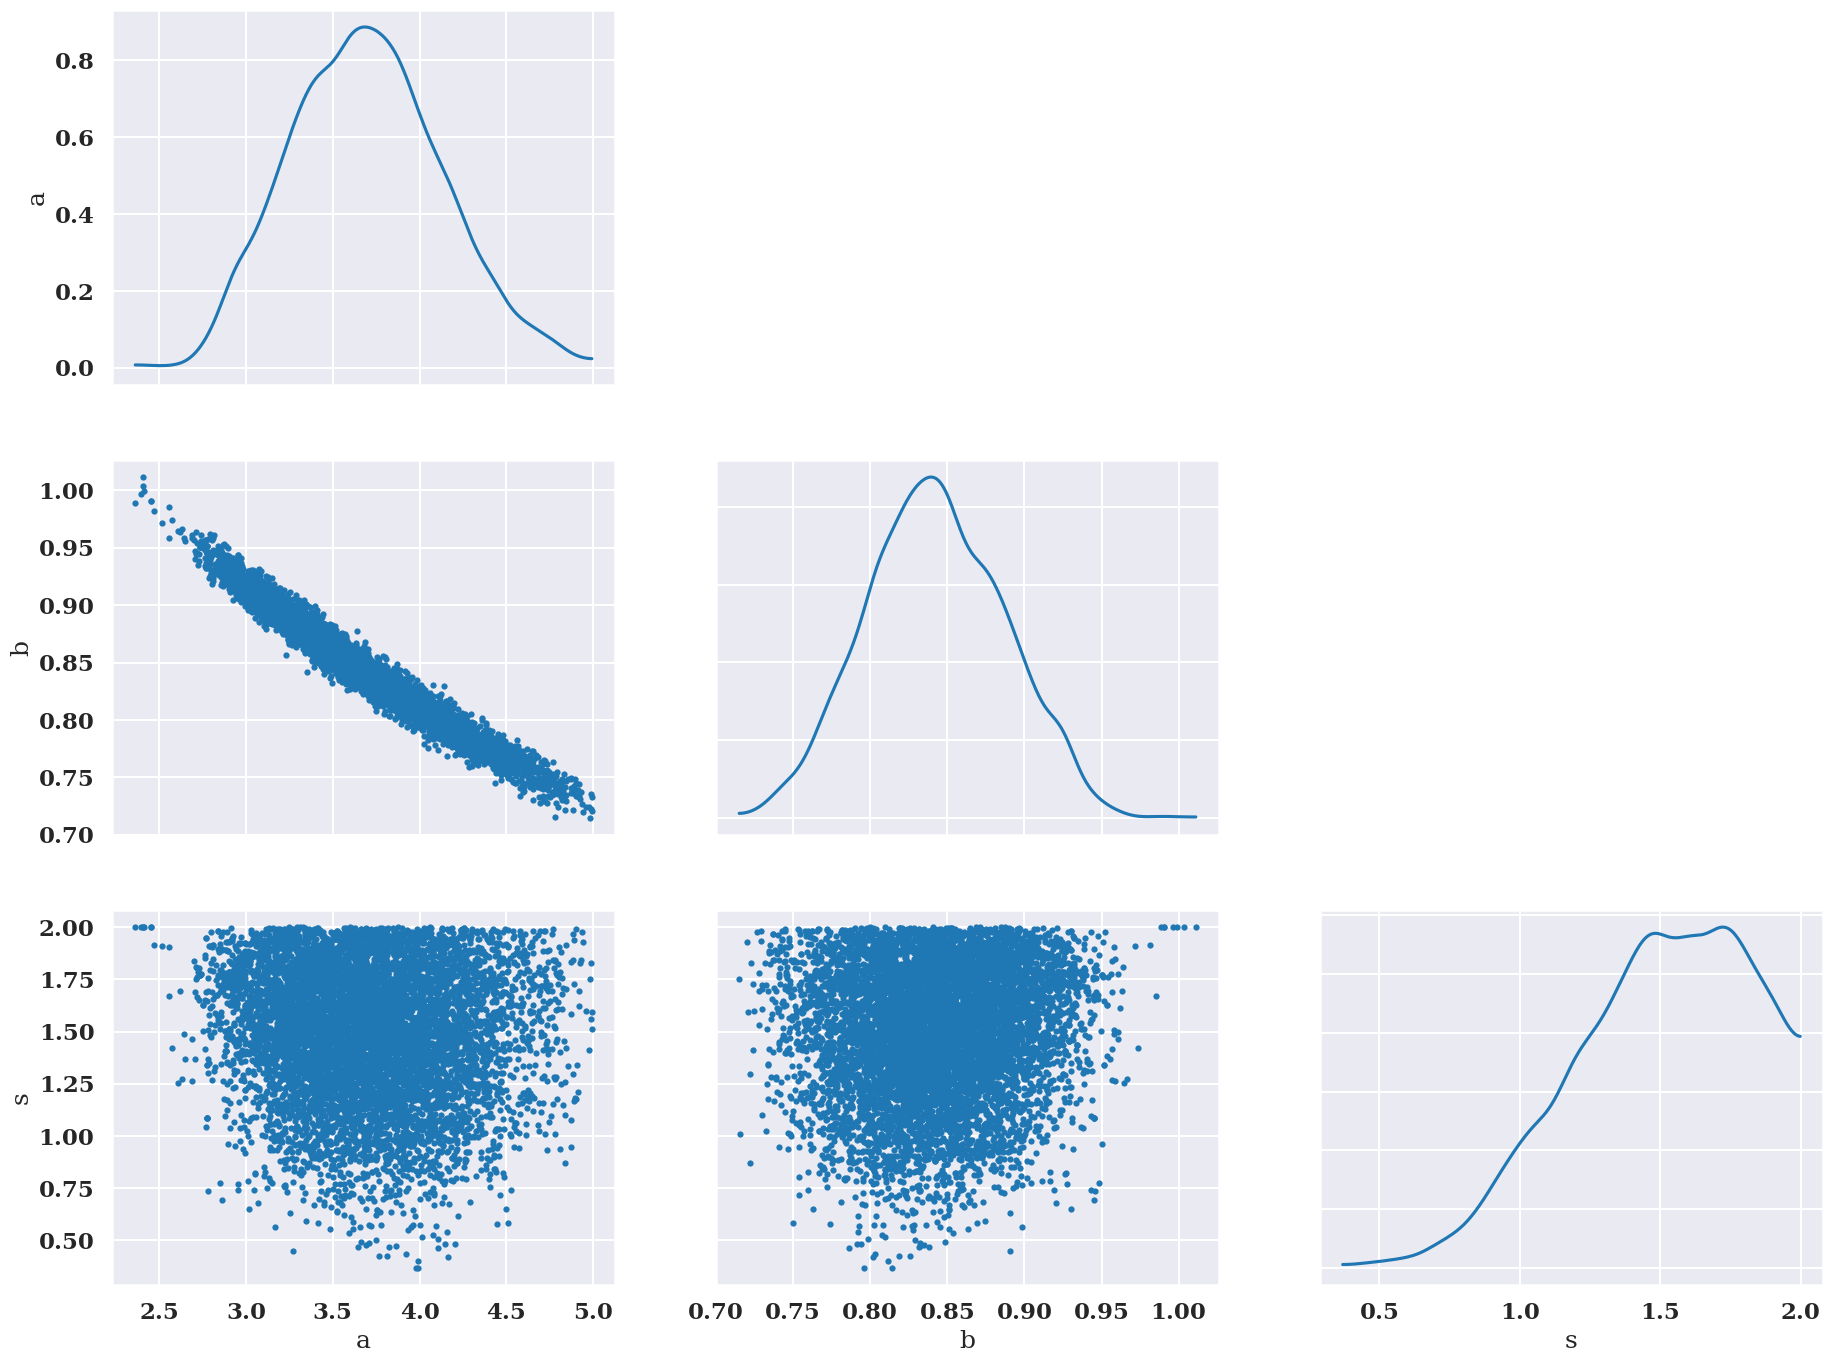

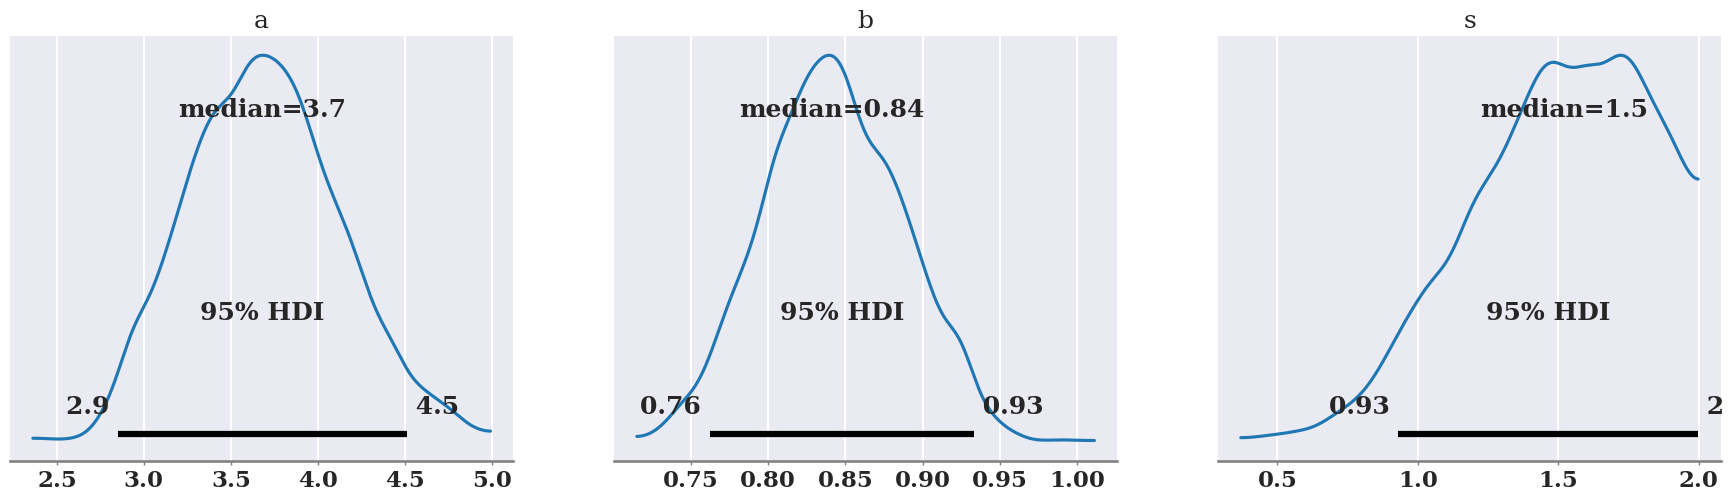

In [48]:
# <your turn>


az.plot_pair(contingency.XRB_model_mcmc_sample, group="posterior",var_names=["a","b","s"],marginals=True)


az.plot_posterior(contingency.XRB_model_mcmc_sample, var_names=['a','b','s'],hdi_prob=0.95,point_estimate='median')


a: point estimate from the median: 3.7, 95% HDI between 2.9 and 4.5


b: point estimate from the median: 0.84, 95% HDI between 0.76 and 0.93


s: point estimate from the median: 1.5, 95% HDI between 0.93 and 2

### Interpreting the results

#### Q10: Interpret the posterior distribution of $s$. Does our model suggest that the uncertainty on measured cluster mass values are underestimated? Provide evidence and/or quantify constraint. [4 points]

`<your turn>`

The posterior distribution of *s* has a 95% HDI between 0.93 and 2, with a median of 1.5. We defined s as having an upper boundary of 2, so this might not accurately describe the full picture. Visually in the plots above, if we imagine the shape of the s distribution continuing, it seems that the HDI range is shifted towards the low tail of the distribution. This interpretation is supported by the upper boundary being the upper end of the confidence interval.

[WRONG DATA] The model is too bad a fit to the data to firmly suggest whether our uncertainty on measured cluster mass values are actually underestimated. The error would need to be much higher on the mass measurements to fit to the model, but that is more due to the model being bad than the uncertainties being underestimated.

[CONTINGENCY DATA] The model suggests that the uncertainty may be underestimated, and we should have used a higher upper bound for the distribution of *s*.

**End of questions**

Make sure that you:

- [x] Typed in your name in the first cell of the Notebook.
- [ ] Saved the Notebook after your modifications.
- [ ] Cleaned the Notebook: if you have added cells/work to test items that are not requested, remove them.
- [ ] Tested the Notebook and that the notebook can be executed in a single sequential run.
- [ ] Make sure that every cell that should have an output, has an output displayed.
- [ ] If you're using Binder, save and download the completed Notebook.
- [ ] Upload the finished notebook to Blackboard (as Jupyter Notebook)


**End of Exam**